# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import f1_score

%matplotlib inline

# Reading the User Item Interactions csv file 
df = pd.read_csv('data/user-item-interactions.csv')

# Reading the Articles Community csv file 
df_content = pd.read_csv('data/articles_community.csv')

# Deleting the Unamed column from both the dataframes
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head(3)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2


In [5]:
# Random sample to check the data in the dataframe
df_content.sample(5)

,doc_body,doc_description,doc_full_name,doc_status,article_id
54,Jump to navigation\r\n\r\n * Twitter\r\n * Lin...,Discover eight ways that Apache Spark’s machin...,8 ways to turn data into value with Apache Spa...,Live,54
656,Skip navigation Sign in SearchLoading...\r\n\r...,Watch this video to see how to create a projec...,Create a project for Watson Machine Learning i...,Live,655
504,HOW-TO: CONNECTING TO COMPOSE MONGODB WITH JAV...,We've heard from some Compose users that conne...,Connecting to Compose MongoDB with Java and SSL,Live,503
683,Homepage Follow Sign in / Sign up Homepage * H...,Working with notebooks in Data Science Experie...,Easy JSON Loading and Social Sharing in DSX No...,Live,682
1028,Compose The Compose logo Articles Sign in Free...,"With the latest 0.2.1 version of Transporter, ...",How to move data with Compose Transporter - Fr...,Live,1023


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [6]:
# Checking the null values in the df - User Item Interactions 
df.isnull().sum()


article_id     0
title          0
email         17
dtype: int64

In [7]:
# Checking the null values in the df df_content - Articles Community  
df_content.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [8]:
# Checking the shapre of the both the dataframe
print(" --->", df.shape)
print("Shape of the Rows & Columns in Articles Community --->",df_content.shape) 

 ---> (45993, 3)
Shape of the Rows & Columns in Articles Community ---> (1056, 5)


In [9]:
# Articles which are most read in the dataset
df['article_id'].value_counts().nlargest(5)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

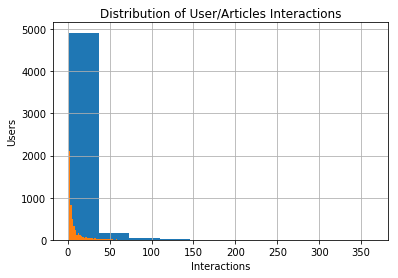

In [10]:
# Visualization to show the number of times each user interacts with an article.
df_user_interactions = df.groupby('email').count()['article_id']
df_user_interactions.hist(bins=10)

plt.hist(df_user_interactions.values, bins=200)
plt.title('Distribution of User/Articles Interactions')
plt.xlabel('Interactions')
plt.ylabel('Users')
plt.show()

In [11]:
# Descriptive statistics

df_user_interactions.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [12]:
# Median value of the DataFrame - Users Interactions
df_user_interactions.median()

3.0

In [13]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3.0 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [14]:
# Find and explore duplicate articles
print("Number of Duplicate Articles-->",df_content.article_id.count() - df_content.article_id.nunique())

Number of Duplicate Articles--> 5


In [15]:
# Explore duplicate articles

df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [17]:
# Remove any rows that have the same article_id - only keep the first

df_content.drop_duplicates('article_id',keep='first',inplace=True)

In [18]:
# check if the duplicates have been removed
print("Number of Duplicate Articles-->",df_content.article_id.count() - df_content.article_id.nunique())
print("Total Records--->",df.shape[0])

df_content[df_content.duplicated() == True].count()

Number of Duplicate Articles--> 0
Total Records---> 45993


doc_body           0
doc_description    0
doc_full_name      0
doc_status         0
article_id         0
dtype: int64

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [19]:
# Number of unique articles
unique_articles = df['article_id'].nunique()

In [20]:
# Total Articles
total_articles = df_content.article_id.count()

In [21]:
# Unique users
unique_users =  df['email'].nunique()

In [22]:
# User Article Interactions
user_article_interactions = df.shape[0]

In [23]:
# Printing the values
print("The number of unique articles that have at least one interaction--->",unique_articles)
print("The number of unique articles on the IBM platform--->",total_articles)
print("The number of unique users--->",unique_users)
print("The number of user-article interactions--->",user_article_interactions)

The number of unique articles that have at least one interaction---> 714
The number of unique articles on the IBM platform---> 1051
The number of unique users---> 5148
The number of user-article interactions---> 45993


In [24]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [25]:
# find the most viewed article_id
df.groupby(by='article_id').count().sort_values(by='email', ascending=False).head()


,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [27]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [28]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [29]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [30]:
# Creating the top article dataframe

top_articles = list(df.groupby(by='title').count().sort_values(by='user_id', ascending=False).head(6).index)

In [31]:
# printing and checking the top 5 records of the top articles
top_articles

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo']

In [32]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Grouping by the 'Title' and then sorting by the user ID in the descending order
    
    top_articles = list(df.groupby(by='title').count().sort_values(by='user_id', ascending=False).head(n).index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    # Grouping by the Article ID and then sorting by the user ID in the descending order
    
    top_articles = list(df.groupby(by='article_id').count().sort_values(by='user_id', ascending=False).head(n).index)
 
    return top_articles # Return the top article ids

In [33]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [34]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [35]:
# Viewing the top 5 records of the dataframe
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [36]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    user_item = df.groupby(by=['user_id', 'article_id']).agg(lambda x: 1).unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [37]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [38]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = {}
    for user in user_item.index:
        similarity[user] = np.dot(user_item.loc[user_id, :], user_item.loc[user, :])

    # sort by similarity
    sorted_similarity = sorted(similarity.items(), key=lambda kv: kv[1], reverse=True)

    # create list of just the ids
    most_similar_users = [key for (key, value) in sorted_similarity]
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [39]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [40]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # a list of article names associated with the list of article ids 
    article_names = [df[df['article_id']==float(id)]['title'].values[0] for id in article_ids]    
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # a list of the article_ids and article titles that have been seen by a user
    article_ids = [str(id) for id in list(user_item.loc[user_id][user_item.loc[user_id]==1].title.index)]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Using for loop for the similar users
    recs = []
    most_similar_users = find_similar_users(user_id)
    the_user_articles, the_article_names = get_user_articles(user_id)
    for user in most_similar_users:
        article_ids, article_names = get_user_articles(user)
        for id in article_ids:
            if id not in the_user_articles:
                recs.append(id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
                break
    
    if len(recs) < m:
        for id in str(df['article_id']):
            if id not in the_user_articles:
                recs.append(id)
            if len(recs) >= m:
                    break
    
    
    return recs # return your recommendations for this user_id    

In [41]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [42]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [43]:
# Neighbours dataframe based on the Neighbor Id, Similarity between articles and number of the interactions
neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])


In [44]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Creating the neighbour dataframe based on the Neighbor ID, Similarity and Number Interactions
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])
    for user in user_item.index:
        if user == user_id:
            continue
        neighbors_df.loc[user] = [user, np.dot(user_item.loc[user_id, :], user_item.loc[user, :]),
                                  df[df['user_id']==user]['article_id'].count()]
    
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Creating a blank recs array
    recs = []
    
    # Getting the top sorted users into to the neighbors dataframe
    neighbors_df = get_top_sorted_users(user_id)
    
    
    the_user_articles, the_article_names = get_user_articles(user_id)
    
    # Loop through the neighbors dataframe based on the neighbor id
    for user in neighbors_df['neighbor_id']:
        article_ids, article_names = get_user_articles(user)
        for id in article_ids:
            if id not in the_user_articles:
                recs.append(id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
                break

    if len(recs) < m:
        for id in [str(id) for id in get_top_article_ids(100)]:
            if id not in the_user_articles:
                recs.append(id)
            if len(recs) >= m:
                    break
    
    rec_names = get_article_names(recs)
    
    #returing recs and rec names from the function defination
    return recs, rec_names

In [45]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'tensorflow quick tips', 'statistics for hackers', 'neural networks for beginners: popular types and applications', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'accelerate your workflow with dsx', 'challenges in deep learning', 'dsx: hybrid mode', 'introduction to neural networks, advantages and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [46]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0]# Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9]# Find the 10th most similar user to user 131

In [47]:
# Printing the results of the dictionary 

print("the user that is most similar to user 1 --->", user1_most_sim)
print("the 10th most similar user to user 131 ---->", user131_10th_sim)

the user that is most similar to user 1 ---> 3933
the 10th most similar user to user 131 ----> 242


In [48]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Given a new user when logged into the IBM Watson Studio for searching articles with no previos browsing history, the most appropriate solution would be to recommend the the most popular articles across the user base. I would suggest to use get_top_article_ids would be a efficient for making recommendations to the new user because the user didn't view any articles before and we don't have any information about user.**




`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [49]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id) for id in get_top_article_ids(10)] # Your recommendations here



In [50]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [51]:
import seaborn as sns
import re
#import progressbar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score


# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'wordnet', 'stopwords',
               'averaged_perceptron_tagger'])

# Pretty display for notebooks
%matplotlib inline
%config InlineBachend.figure_format = 'retina'

# Enable pep8 code style test
#%load_ext pycodestyle_magic

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [52]:
def tokenize(text):
    """Function to tokenize an article title

    Args:
        text (str) title

    return:
        tokens (list) a list of words

    """

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words]
    # remove short words
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [53]:
def create_article_content_dataframe(df=df, df_content=df_content):
    '''
    INPUT:
    df - pandas dataframe describe user interaction with th articles
    df_content - pandas dataframe describe articles on the platforme
    OUTPUT:
    df_total - pandas dataframe contains all articles in the platforme
    article_content -  pandas dataframe describe the content of each
                       article on the plateforme

    Description:
    Return a pandas dataframe contains all the articles in the platforme
    with thier titles and a pandas dataframe describes the content of each
    article base on the article title.
    '''

    # Get a dataframe of the full articles
    df_1 = df[['article_id', 'title']]
    df_2 = pd.DataFrame({'article_id': df_content.article_id.values,
                         'title': df_content. doc_full_name})
    df_total = pd.concat([df_1, df_2], ignore_index=True)
    df_total.drop_duplicates(subset=['article_id'], inplace=True)
    df_total.sort_values(by='article_id', inplace=True)
    df_total.reset_index(drop=True, inplace=True)

    # TfidfVectorizer
    vectorizer = TfidfVectorizer(tokenizer=tokenize)
    df_vec = pd.DataFrame(vectorizer.fit_transform(
                          df_total.title.values).toarray(),
                          columns=[*vectorizer.vocabulary_])

    # concat  df_total and df_vec
    df_articles = pd.concat([df_total, df_vec], axis=1)

    return df_total, df_articles


df_total, df_articles = create_article_content_dataframe()

In [50]:
# Viewing the top 5 records of the dataframe
df_total.head()

,article_id,title
0,0.0,detect malfunctioning iot sensors with streami...
1,1.0,Communicating data science: A guide to present...
2,2.0,"this week in data science (april 18, 2017)"
3,3.0,DataLayer Conference: Boost the performance of...
4,4.0,analyze ny restaurant data using spark in dsx


In [54]:
def create_article_similarity_dataframe(df=df_articles):
    '''
    INPUT:
    df - pandas dataframe describe articles content
    OUTPUT:
    article_content -  pandas dataframe describe articles similarities

    Description:
    Return a pandas dataframe that describe the articles similarities
    using the dot product.
    '''

    # subset articles content
    article_content = np.array(df_articles.iloc[:, 2:])

    # Take the dot product to obtain a article x article matrix of similarities
    dot_prod_article = article_content.dot(np.transpose(article_content))

    # checks the dot product
    assert dot_prod_article.shape[0] == len(df_articles)
    assert dot_prod_article.shape[1] == len(df_articles)

    # make a Dataframe
    article_similarity = pd.DataFrame(dot_prod_article,
                                      index=df_articles.article_id,
                                      columns=df_articles.article_id)

    return article_similarity


article_similarity = create_article_similarity_dataframe()

In [55]:
# Viewing the top 5 records in the article similarity dataframe
article_similarity.head()

article_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
article_id,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1.0,0.0,1.000000,0.123927,0.0,0.027770,0.033650,0.0,0.032382,0.125929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.032878,0.015730,0.0,0.0,0.0
2.0,0.0,0.123927,1.000000,0.0,0.039464,0.047820,0.0,0.046017,0.424907,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.046723,0.022353,0.0,0.0,0.0
3.0,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4.0,0.0,0.027770,0.039464,0.0,1.000000,0.041185,0.0,0.039633,0.040102,0.130353,...,0.0,0.0,0.0,0.0,0.0,0.040241,0.019252,0.0,0.0,0.0


In [56]:
def top_user_articles(user_id, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) dataframe of user interaction

    OUTPUT:
    article_ids - (list) a sorted list of the article ids seen by the user

    Description:
    Provides a list of the  article_ids sorted by interactions number
    '''

    df_user = df[df.user_id == 1]
    df_user = df_user.groupby('article_id').count()
    df_user.sort_values('user_id', ascending=False, inplace=True)

    count_article = df_user.user_id.unique()
    article_ids = []
    for k in count_article:
        ids = df_user[df_user.user_id == k].index
        article_ids.append(list(ids))

    return article_ids

In [57]:
def make_content_recs(user_id, m=10, df_smly=article_similarity, thd=1):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    df_smly - (pandas dataframe) pandas dataframe that describe the articles
    similarities using the dot product

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''

    list_ids = top_user_articles(user_id)
    recs = []

    for ids in list_ids:
        top_articles = article_similarity.loc[ids].sum()
        top_articles.sort_values(ascending=False, inplace=True)
        top_articles = top_articles[top_articles >= thd]
        article_not_recs = np.setdiff1d(np.array(top_articles.index),
                                        np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    recs = recs[:10]
    rec_names = get_article_names(recs, df=df_total)

    return recs, rec_names

In [58]:
# Getting the  user id who only has interacted with article id '1427.0' and then creating the dataframe df_1427 followed by grouping
# on the user ID 
df_1427 = df[df.article_id == 1427.0].groupby('user_id').count()
user_1427 = df_1427.sort_values('article_id').index[0]

# Make recomendation based on the article id 1427
make_content_recs(user_1427)

([310.0, 585.0, 668.0, 1052.0, 1170.0, 1183.0, 1185.0, 1363.0, 1406.0, 1430.0],
 ['time series prediction using recurrent neural networks (lstms)',
  'tidyverse practice: mapping large european cities',
  'shiny: a data scientist’s best friend',
  'access db2 warehouse on cloud and db2 with python',
  'apache spark lab, part 1: basic concepts',
  'categorize urban density',
  'classify tumors with machine learning',
  'predict loan applicant behavior with tensorflow neural networking',
  'uci: iris',
  'using pixiedust for fast, flexible, and easier data analysis and experimentation'])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [56]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [59]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [60]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [63]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [64]:
# Checking the u.shape, s.shape, vt.shape
print("u.shape --->",u.shape)
print("s.shape --->",s.shape)
print("vt.shape --->", vt.shape)

u.shape ---> (5149, 5149)
s.shape ---> (714,)
vt.shape ---> (714, 714)


**In the above cell I have performed the SVD but this is different in this part of the lesson because user_item_matrix contains the rating but here we have to obtain the status whether the user has viewed the article or not**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

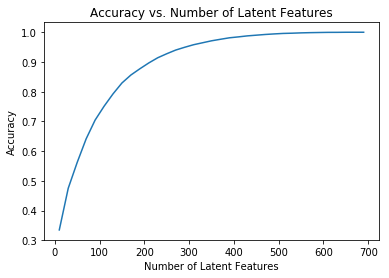

In [61]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [83]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(user_item_test.index.values)
    test_arts = user_item_test.title.columns.values
    
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
     
    # returning the values back
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [84]:
# Checking the top  5 records of the User Item Training Dataset
user_item_train.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
1             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
4             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                   ...                                                     \
article_id 18.0    ...   1434.0 1435.0 1436.0 1437.0 1439.0 1440.0 1441.0   
user_id            ...                                                      
1             0.0  ...      0.0    0.0    1.0    0.0    1.0    0.0    0.0   
2             0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3             0.0  ...      0.0    0.0    1.0    0.0    0.0    0.0    0.0   
4             0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5             0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1442.0 1443.0 1444.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  

[5 rows x 714 columns]

In [85]:
# Total numbers of rows and columns in the Test and Train dataset
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [89]:
# find the common users in both test and train set
common_idx = user_item_train.index.isin(test_idx)

In [87]:
common_idx.sum()

20

In [90]:
# total number of user in test set
len(test_idx)

682

In [78]:
#common_arts.sum()

In [91]:
# How many users can we make predictions for in the test set?
len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

20

In [92]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['user_id'].unique()) - len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

662

In [93]:
# How many articles can we make predictions for in the test set?
len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

574

In [94]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

0

In [95]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [96]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [97]:
#Viewing the shape of the u_train, s_train,vt_train

u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [98]:
## users in test set that can be predicted (because also in training set)
u_test = u_train[user_item_train.index.isin(test_idx), :]
u_test.shape[0]

20

In [99]:
# Checking the user_item_train index
user_item_train.index.isin(test_idx)

array([False, False, False, ..., False, False,  True], dtype=bool)

In [100]:
#Viewing the data in the u_test
u_test

array([[ -9.12128414e-03,  -1.04593665e-02,  -3.44661555e-05, ...,
         -1.79527638e-04,   1.57363124e-04,  -2.22606585e-03],
       [ -4.23484921e-02,  -8.80195536e-02,   2.37441056e-02, ...,
         -9.64599546e-04,   1.09471046e-03,  -4.16064153e-03],
       [ -1.08548005e-02,  -4.07260013e-02,  -6.40519993e-03, ...,
          2.48133636e-03,   2.85137940e-03,   4.37297957e-03],
       ..., 
       [ -2.00584196e-02,   4.52035654e-03,   1.40205893e-03, ...,
         -1.99000075e-03,  -2.18702165e-03,  -6.78878413e-03],
       [ -4.34321936e-02,   4.29457303e-02,   3.35667405e-02, ...,
         -3.96677563e-03,   1.23123106e-02,  -1.34565016e-02],
       [ -1.61097454e-02,  -6.66008794e-03,   7.28103953e-03, ...,
         -2.79762572e-04,  -1.37741965e-04,   4.87579480e-01]])

In [101]:
# movies in test set that can be predicted (because also in training set)
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
vt_test.shape[1]

574

In [102]:
# Creating the user items test with the intersection of the user item train and test articles

user_item_test_reduced = user_item_test.loc[user_item_train.index.intersection(test_idx), user_item_train.columns.intersection(test_arts)]



In [103]:
# Viewing the shape of the user item test reduced dataset
user_item_test_reduced.shape

(20, 574)

In [104]:
# calculating the balance of the reduced test dataset
test_have_score = user_item_test_reduced[user_item_test_reduced != 0].count().sum()
test_have_no_score = user_item_test_reduced[user_item_test_reduced == 0].count().sum()
perc_test_have_score = round((test_have_score/(test_have_score+test_have_no_score))*100,3)
perc_test_have_no_score = round((test_have_no_score/(test_have_score+test_have_no_score))*100,3)
print('In the reduced test data set  :')
print('{} relations user/movie have a score or {} % of the reduced test set'.format(test_have_score,perc_test_have_score))
print('{} relations user/movie have no score or {} % of the reduced test set'.format(test_have_no_score,perc_test_have_no_score))

In the reduced test data set  :
218 relations user/movie have a score or 1.899 % of the reduced test set
11262 relations user/movie have no score or 98.101 % of the reduced test set


In [105]:
# Use these cells to see how well you can use the training
num_latent_feats = np.arange(10,700+10,20)

sum_errs_train = []
sum_errs_test = []

sum_f1_train_score = []
sum_f1_test_score = []

for k in num_latent_feats:
    
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_est = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_est)
    diffs_test = np.subtract(user_item_test_reduced, user_item_test_est)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)
    
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    train_error = round((1 - np.array(sum_errs_train)/df_train.shape[0])[-1],3)
    test_error = round((1 - np.array(sum_errs_test)/df_test.shape[0])[-1],3)
    f1_train_score = round(f1_score(np.array(user_item_train).flatten(), np.array(user_item_train_est).flatten(),average='weighted',labels=[1.0]),3)
    f1_test_score = round(f1_score(np.array(user_item_test_reduced).flatten(), np.array(user_item_test_est).flatten(),average='weighted',labels=[1.0]),3)
    
    sum_f1_train_score.append(f1_train_score)
    sum_f1_test_score.append(f1_test_score)
    
    print('Latent Features : {} | Training Accuracy : {} Training F1 : {} | Testing Accuracy : {} | Testing F1 : {}'.format(k,train_error,f1_train_score,test_error,f1_test_score))
    #print('0 correclty identified : {} | 1 correcly identifed : {}'.format())
    # decomposition to predict on test data

Latent Features : 10 | Training Accuracy : 0.336 Training F1 : 0.2 | Testing Accuracy : 0.959 | Testing F1 : 0.075
Latent Features : 30 | Training Accuracy : 0.478 Training F1 : 0.455 | Testing Accuracy : 0.955 | Testing F1 : 0.124
Latent Features : 50 | Training Accuracy : 0.567 Training F1 : 0.583 | Testing Accuracy : 0.953 | Testing F1 : 0.129
Latent Features : 70 | Training Accuracy : 0.646 Training F1 : 0.682 | Testing Accuracy : 0.949 | Testing F1 : 0.127
Latent Features : 90 | Training Accuracy : 0.709 Training F1 : 0.752 | Testing Accuracy : 0.947 | Testing F1 : 0.131
Latent Features : 110 | Training Accuracy : 0.756 Training F1 : 0.8 | Testing Accuracy : 0.943 | Testing F1 : 0.124
Latent Features : 130 | Training Accuracy : 0.798 Training F1 : 0.84 | Testing Accuracy : 0.942 | Testing F1 : 0.125
Latent Features : 150 | Training Accuracy : 0.832 Training F1 : 0.87 | Testing Accuracy : 0.94 | Testing F1 : 0.127
Latent Features : 170 | Training Accuracy : 0.858 Training F1 : 0.89

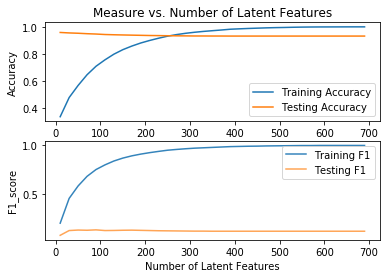

In [106]:
# Plotting the graph

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Accuracy');
ax1.set_title('Measure vs. Number of Latent Features');
ax1.plot(num_latent_feats,1 - np.array(sum_errs_train)/df_train.shape[0],label = 'Training Accuracy');
ax1.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df_test.shape[0],label = 'Testing Accuracy');
plt.legend()
ax2 = fig.add_subplot(212)
ax2.plot(num_latent_feats,sum_f1_train_score,label = 'Training F1',alpha=0.9);
ax2.plot(num_latent_feats,sum_f1_test_score,label = 'Testing F1',alpha=0.7);
plt.xlabel('Number of Latent Features');
plt.ylabel('F1_score');
plt.legend()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**The important thing to note is that we only have a limited sample of 20 users in which to make predictions on and generalize the model. This is a very small sample to base any good conclusions. And even though the accuracy score seems very high this is largely due to the imbalance between the two classes, we have many more 0's than 1's.Increasing the latent features causes overfitting problem. Thus we can see from the above graph, the accuracy becomes worser when the number of latent features increases.But it is a misleading result because we have a class imbalance in your data. In fact, the data contain much more zeros than ones.The training accuracy increase to near 100% as the number of latent features increases.
The possbile solution to the above problem is to use the Cross Validation to determine the latent features which allow the model to see different subsets of the datasets. **

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])